In [84]:
import pandas as pd
import numpy as np

In [1]:
# --- PATHS & FLAGS ----------------------------------------------------
from pathlib import Path
import pandas as pd, requests, io

# Base URL of my GitHub repo (raw view)
BASE_URL = ("https://raw.githubusercontent.com/"
            "Eugine-Srb/Sales-Forecasting_2024-Project/main/")


DATA_PROC_URL = BASE_URL + "data/processed/"     # for imports

# Local fallback folders (never pushed)
EXPORT_DIR = Path("../scratch_outputs")
EXPORT_DIR.mkdir(exist_ok=True)

# Master switch — keep False unless *really* want to re-export
SAVE_OUTPUTS = False

In [2]:
# Load the Product Sales Interpolated dataset

def load_processed(name: str) -> pd.DataFrame:
    """Load a frozen CSV straight from GitHub raw URL."""
    url = DATA_PROC_URL + name
    return pd.read_csv(url, low_memory=False)   # pandas handles https URLs

# EXAMPLE
df = load_processed("03-product_sales_interpolated_data.csv")

C:\Users\eugin\anaconda_3\Lib\ssl.py:524: UserWarning: Bad certificate in Windows certificate store: not enough data: cadata does not contain a certificate (_ssl.c:3964)
  warnings.warn(f"Bad certificate in Windows certificate store: {exc!s}")


In [86]:
# Exploaring dataset
df.head()

,Date,Product,Units_Sold,Unit_Price,Month,Year,Revenue,Interpolated_Flag
0,2019-01-01,Alpha,146.0,100.151629,Jan,2019,14622.137902,False
1,2019-02-01,Alpha,144.0,120.196688,Feb,2019,17308.323033,False
2,2019-03-01,Alpha,129.0,59.398194,Mar,2019,7662.367024,False
3,2019-04-01,Alpha,136.0,96.559802,Apr,2019,13132.133047,False
4,2019-05-01,Alpha,129.0,109.083326,May,2019,14071.749061,False


In [87]:
df.describe()

,Units_Sold,Unit_Price,Year,Revenue
count,240.000000,240.000000,240.000000,240.000000
mean,119.972917,98.178586,2021.000000,11817.692653
std,15.781533,28.255294,1.417169,3838.159217
min,85.000000,51.300192,2019.000000,4633.483394
25%,107.000000,74.480488,2020.000000,8733.032319
50%,118.000000,97.702472,2021.000000,11675.506735
75%,131.000000,121.024481,2022.000000,14643.557118
max,160.000000,149.050514,2023.000000,22043.607778


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               240 non-null    object 
 1   Product            240 non-null    object 
 2   Units_Sold         240 non-null    float64
 3   Unit_Price         240 non-null    float64
 4   Month              240 non-null    object 
 5   Year               240 non-null    int64  
 6   Revenue            240 non-null    float64
 7   Interpolated_Flag  240 non-null    bool   
dtypes: bool(1), float64(3), int64(1), object(3)
memory usage: 13.5+ KB


In [89]:
# Inspect NaN values
df.isna().sum()

Date                 0
Product              0
Units_Sold           0
Unit_Price           0
Month                0
Year                 0
Revenue              0
Interpolated_Flag    0
dtype: int64

In [90]:
# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [91]:
# Aggregate total monthly Revenue and ensure the index has a Monthly Start frequency
df_monthly_revenue = df.groupby('Date')['Revenue'].sum().asfreq('MS')

In [92]:
# Inspect NaN in a new dataset
df_monthly_revenue.isna().sum()

0

In [93]:
# Check dataset's shape and time range
print(df_monthly_revenue.shape)
print(df_monthly_revenue.index.min(), df_monthly_revenue.index.max())

(60,)
2019-01-01 00:00:00 2023-12-01 00:00:00


In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [95]:
# Function to evaluate SARIMA models over all parameter combinations using AIC as selection criterion
def evaluate_sarima(series, pdq, seasonal_pdq, seasonal_period=12):
    import statsmodels.api as sm
    results = []

    for param in pdq:
        for seasonal in seasonal_pdq:
            try:
                model = sm.tsa.statespace.SARIMAX(
                    series,
                    order=param,
                    seasonal_order=(seasonal[0], seasonal[1], seasonal[2], seasonal_period),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                ).fit(disp=False)

                seasonal = seasonal + (12,)
                
                results.append({
                    'order': param,
                    'seasonal_order': seasonal,
                    'aic': model.aic,
                    'model': model
                })

            except Exception as e:
                continue  # skip failed combinations

    return sorted(results, key=lambda x: x['aic']) 

In [96]:
# Starting pipeline function and recieving results
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q))

# Run the SARIMA model selection pipeline
pipeline_results = evaluate_sarima(df_monthly_revenue, pdq, seasonal_pdq)

C:\Users\eugin\anaconda_3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eugin\anaconda_3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eugin\anaconda_3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eugin\anaconda_3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\eugin\anaconda_3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: M

In [97]:
# Function to compute diagnostics for model comparison
def comparison(comparison_data):
    return {
        'MAE': np.mean(np.abs(comparison_data)),             # Mean Absolute Error
        'RMSE': np.sqrt(np.mean(comparison_data**2)),        # Root Mean Squared Error
        'Std Dev': np.std(comparison_data),                  # Spread of errors
        'Mean': np.mean(comparison_data),                    # Should be near 0
        'Max Residual': np.max(np.abs(comparison_data))      # Largest single error
    }

In [98]:
# Fit SARIMA model, display summary, plot residuals and forecast
def model_results(df_monthly_revenue, order_config, seasonal_config):
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    import matplotlib.pyplot as plt
    
    model = SARIMAX(
        df_monthly_revenue,
        order=order_config,
        seasonal_order=seasonal_config,
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = model.fit(disp=False)
    display(results.summary())
    
    residuals = results.resid
    plt.figure(figsize=(10, 4))
    plt.plot(residuals)
    plt.title(f"SARIMA Residuals over Time for order={order_config}, seasonal={seasonal_config}")
    plt.grid(True)

    fitted_values = results.fittedvalues
        
    forecast = results.get_forecast(steps=12)
    forecast_values = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()
    
    plt.figure(figsize=(10, 6))
    plt.plot(df_monthly_revenue, label='Observed', color='blue')
    plt.plot(forecast_values, label='Forecast', color='red')
    plt.fill_between(
        forecast_values.index,
        confidence_intervals.iloc[:, 0],
        confidence_intervals.iloc[:, 1],
        color='pink', alpha=0.3
    )
    plt.title(f"SARIMA Forecast: order={order_config}, seasonal={seasonal_config}")
    plt.legend()
    plt.show()
    
    return fitted_values, forecast_values, residuals

In [99]:
# Prepare actual data and historical monthly averages for comparison
df_actual = df_monthly_revenue.copy()
df_actual = df_actual.to_frame(name='Revenue')
df_actual['Month'] = df_actual.index.month
historical_monthly_avg = df_actual.groupby('Month')['Revenue'].mean()
historical_avg = df_actual['Revenue'].mean()

In [100]:
# Initialize result containers for model comparisons
res_comparison = pd.DataFrame()
comparison_annually = []
comparison_monthly = pd.DataFrame()
df_forecast_total = pd.DataFrame()
df_fitted = pd.DataFrame()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                             Revenue   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                -357.633
Date:                             Mon, 14 Jul 2025   AIC                            723.266
Time:                                     22:39:24   BIC                            729.372
Sample:                                 01-01-2019   HQIC                           725.348
                                      - 12-01-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0645      0.289     -0.223      0.823      -0.631       0.502
ma.L1         -0.7634      0.151     -5.049      0.000      -1.060      -0.467
ar.S.L12      -0.6476      0.224     -2.886      0.004      -1.087      -0.208
sigma2      9.473e+07   1.61e-09    5.9e+16      0.000    9.47e+07    9.47e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 5.84
Prob(Q):                              0.94   Prob(JB):                         0.05
Heteroskedasticity (H):               1.14   Skew:                             0.59
Prob(H) (two-sided):                  0.83   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.76e+32. Standard errors may be unstable.
"""

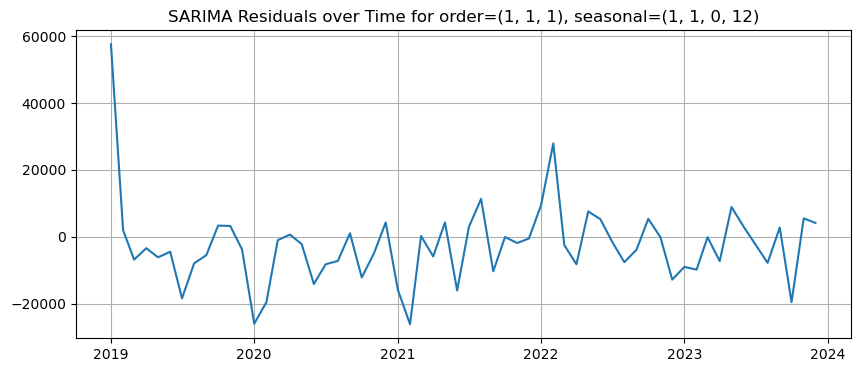

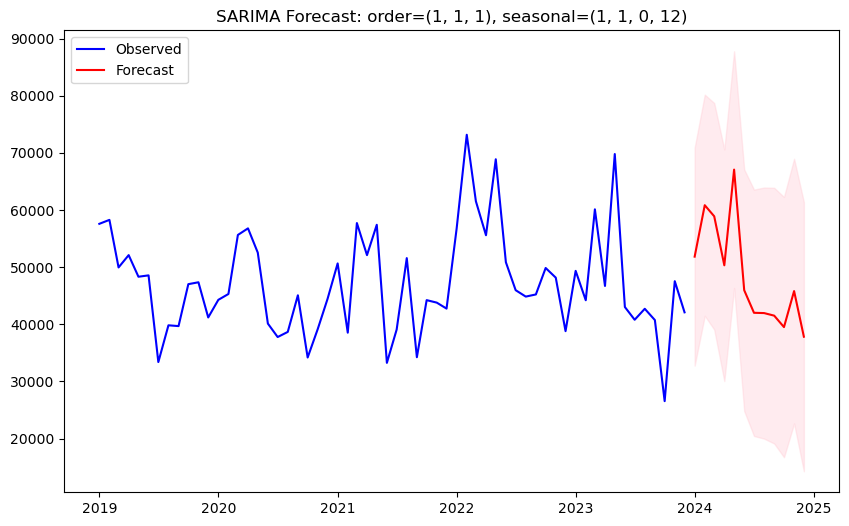

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                   60
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -363.322
Date:                            Mon, 14 Jul 2025   AIC                            732.644
Time:                                    22:39:24   BIC                            737.223
Sample:                                01-01-2019   HQIC                           734.205
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4828      0.174     -2.769      0.006      -0.825      -0.141
ar.S.L12      -0.5459      0.241     -2.261      0.024      -1.019      -0.073
sigma2      1.381e+08   3.23e-10   4.27e+17      0.000    1.38e+08    1.38e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 0.31
Prob(Q):                              0.43   Prob(JB):                         0.86
Heteroskedasticity (H):               0.83   Skew:                            -0.00
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.03e+33. Standard errors may be unstable.
"""

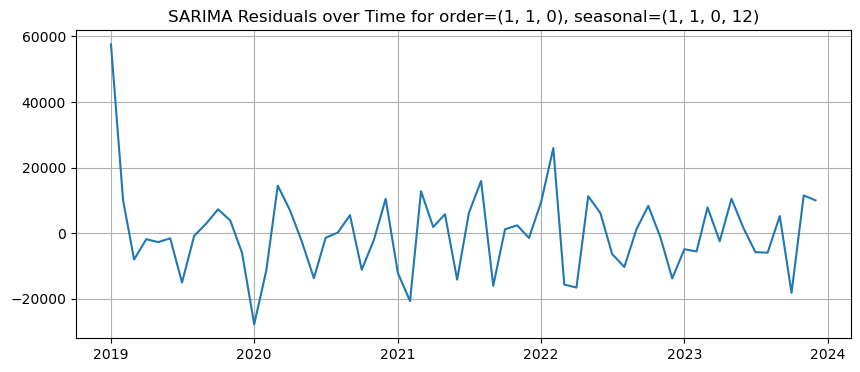

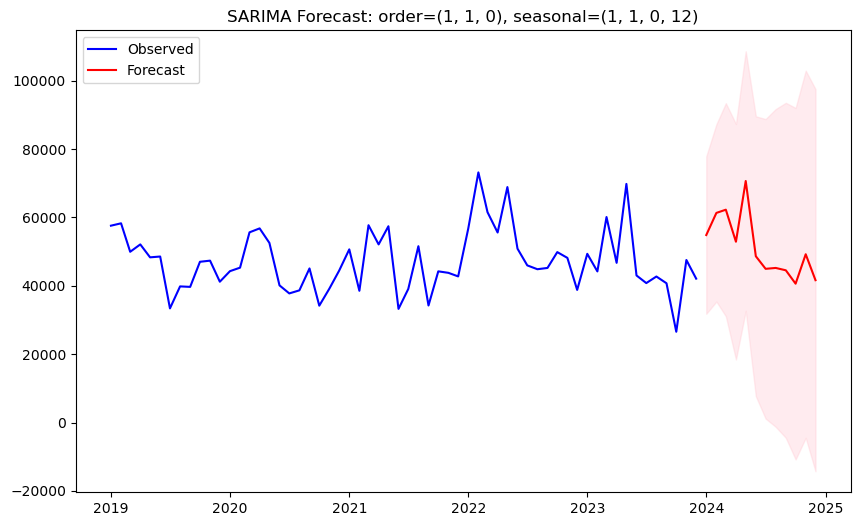

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                   60
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -369.333
Date:                            Mon, 14 Jul 2025   AIC                            744.667
Time:                                    22:39:25   BIC                            749.333
Sample:                                01-01-2019   HQIC                           746.278
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1713      0.261      0.656      0.512      -0.340       0.683
ar.S.L12      -0.5841      0.232     -2.515      0.012      -1.039      -0.129
sigma2      9.939e+07   1.29e-09   7.72e+16      0.000    9.94e+07    9.94e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 2.49
Prob(Q):                              0.69   Prob(JB):                         0.29
Heteroskedasticity (H):               0.80   Skew:                             0.21
Prob(H) (two-sided):                  0.70   Kurtosis:                         4.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

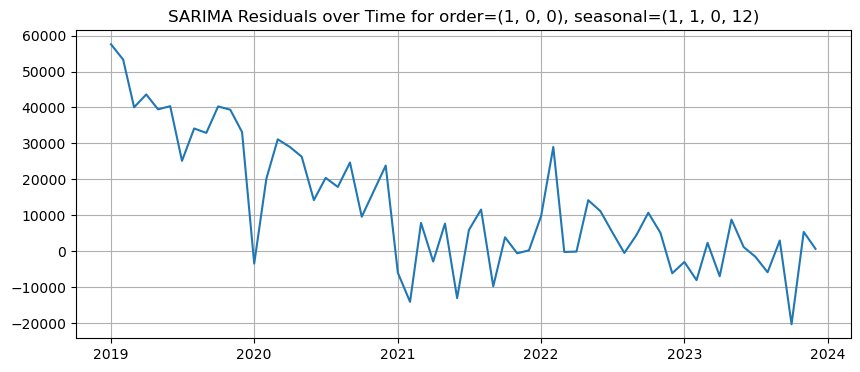

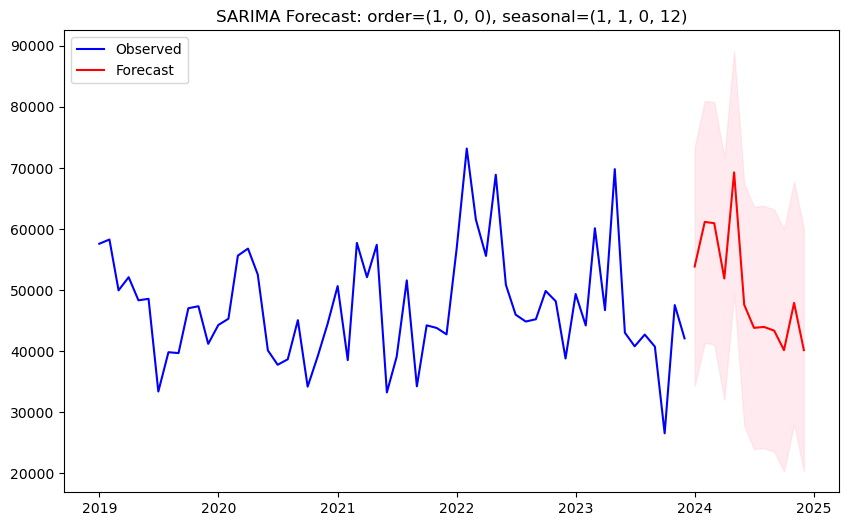

In [101]:
# Fit SARIMA model, display summary, plot residuals and forecast

for num, config in enumerate(pipeline_results[:3]):
    order_config = config['order']
    seasonal_config = config['seasonal_order']
    fitted_values, forecast_values, residuals = model_results(df_monthly_revenue, order_config, seasonal_config)
    
# Enrich residual dataset
    res_comparison[f"Model_{num}"] = comparison(residuals)

# Compare average annual total values with relevant forecast values
    forecast_avg = forecast_values.mean()
    relative_diff = (forecast_avg - historical_avg) / historical_avg
    comparison_summary = {
        'Historical Avg': historical_avg,
        'Forecast Avg': forecast_avg,
        'Relative Diff %': round(100 * relative_diff, 2)
    }
    summary_df = pd.DataFrame(comparison_summary, index=[f'Model_{num}'])
    comparison_annually.append(summary_df)

# Compare average monthly total values with relevant forecast values
    forecast_df = forecast_values.to_frame(name='Forecast')
    forecast_df['Month'] = forecast_df.index.month
    forecast_df['Historical Avg'] = forecast_df['Month'].map(historical_monthly_avg)
    comparison_monthly[f'Model_{num}'] = round(100 * (forecast_df['Forecast'] - forecast_df['Historical Avg']) / forecast_df['Historical Avg'], 2)
    df_forecast_total[f'Model_{num} forecast'] =  forecast_df['Forecast']
    df_fitted[f'Model_{num} fitted'] = fitted_values

In [102]:
# Summary statistics of residuals for Top 3 models (MAE, RMSE, etc.)
res_comparison

,Model_0,Model_1,Model_2
MAE,8210.243476,9193.107480,16073.542885
RMSE,12320.703236,12744.002424,21765.818467
Std Dev,12060.365350,12743.890392,17713.975098
Mean,-2519.387992,-53.436464,12647.764219
Max Residual,57591.136647,57591.136647,57591.136647


In [103]:
# Compare average actual vs. forecasted annual revenue per model
final_df = pd.concat(comparison_annually)
final_df

,Historical Avg,Forecast Avg,Relative Diff %
Model_0,47270.77061,48637.708024,2.89
Model_1,47270.77061,51407.389776,8.75
Model_2,47270.77061,50347.174141,6.51


In [104]:
# Identify the model with the largest deviation from historical monthly average per calendar month
comparison_monthly['Month'] = comparison_monthly.index.strftime('%B')

In [105]:
max_model_per_month = comparison_monthly.drop(columns='Month').abs().idxmax(axis=1)
max_value_per_month = comparison_monthly.drop(columns='Month').abs().max(axis=1)

monthly_behavior = pd.DataFrame({
    'Month': comparison_monthly['Month'],
    'Max Deviation (%)': max_value_per_month.round(2),
    'Responsible Model': max_model_per_month
})

In [106]:
# Compare a deviation between monthly forecast results and average monthly actual data
monthly_behavior

,Month,Max Deviation (%),Responsible Model
2024-01-01,January,6.03,Model_1
2024-02-01,February,18.15,Model_1
2024-03-01,March,9.24,Model_1
2024-04-01,April,4.43,Model_0
2024-05-01,May,18.95,Model_1
2024-06-01,June,12.70,Model_1
2024-07-01,July,14.12,Model_1
2024-08-01,August,3.90,Model_1
2024-09-01,September,8.64,Model_1
2024-10-01,October,2.13,Model_0


In [107]:
# Compute mean % difference from historical average per model across all months
overall_trend = comparison_monthly[['Model_0','Model_1','Model_2']].mean().sort_values()

print("Average % Difference from Historical by Model:")
print(overall_trend)

Average % Difference from Historical by Model:
Model_0    2.472500
Model_2    6.146667
Model_1    8.430833
dtype: float64


In [108]:
# Compute standard deviation of monthly % differences to assess model stability
model_stability = comparison_monthly[['Model_0','Model_1','Model_2']].std().sort_values()

print("Model Stability (Lower Std = More Stable):")
print(model_stability)

Model Stability (Lower Std = More Stable):
Model_1    6.659911
Model_2    6.916293
Model_0    7.516993
dtype: float64


In [109]:
df_actual_only = df_monthly_revenue.to_frame()

In [110]:
df_actual_only.index = pd.to_datetime(df_actual_only.index)
df_actual_only = df_actual_only.rename(columns={'Revenue': 'Actual'})
df_actual_only.head()

,Actual
Date,
2019-01-01,57591.136647
2019-02-01,58282.009925
2019-03-01,49956.076684
2019-04-01,52113.524255
2019-05-01,48329.367865


In [111]:
#df_fitted = fitted_values.to_frame(name='Model_0 fitted')
#df_fitted.index = pd.to_datetime(df_fitted.index)

In [112]:
df_fitted_only = df_fitted[['Model_0 fitted']].copy()
df_fitted_only = df_fitted_only.iloc[1:]
df_fitted_only.index = pd.to_datetime(df_fitted_only.index)
df_forecast_only = df_forecast_total[['Model_0 forecast']].copy()
df_forecast_only.index = pd.to_datetime(df_forecast_only.index)

In [113]:
combined_df = df_actual_only.join(df_fitted_only, how='outer').join(df_forecast_only, how='outer')

In [114]:
combined_df = combined_df.reset_index()
combined_df.rename(columns={'index': 'Date'}, inplace=True)
combined_df['SARIMA_Predicted'] = combined_df['Model_0 fitted'].combine_first(combined_df['Model_0 forecast'])
combined_df

,Date,Actual,Model_0 fitted,Model_0 forecast,SARIMA_Predicted
0,2019-01-01,57591.136647,NaN,NaN,NaN
1,2019-02-01,58282.009925,56351.976153,NaN,56351.976153
2,2019-03-01,49956.076684,56795.799242,NaN,56795.799242
3,2019-04-01,52113.524255,55537.651711,NaN,55537.651711
4,2019-05-01,48329.367865,54481.981991,NaN,54481.981991
...,...,...,...,...,...
67,2024-08-01,NaN,NaN,41967.522052,41967.522052
68,2024-09-01,NaN,NaN,41515.025686,41515.025686
69,2024-10-01,NaN,NaN,39512.196268,39512.196268
70,2024-11-01,NaN,NaN,45818.842896,45818.842896


In [ ]:
def maybe_save(df: pd.DataFrame, filename: str):
    """
    Save to scratch_outputs/ only if SAVE_OUTPUTS is True.
    Prevents overwriting the canonical CSVs in data/processed/.
    """
    if SAVE_OUTPUTS:
        df.to_csv(EXPORT_DIR / filename, index=False)
        print(f"🔸 Saved {filename} to {EXPORT_DIR}")
    else:
        print(f"⏩ Skipped saving {filename} (SAVE_OUTPUTS = False)")

In [ ]:
# Save KDE values
maybe_save(combined_df, "14-best_SARIMA_Model_Project2.csv")

In [116]:
combined_df['Actual'].describe()

count       60.000000
mean     47270.770610
std       9168.676950
min      26551.019066
25%      40783.967825
50%      45641.553858
75%      52112.256643
max      73181.513919
Name: Actual, dtype: float64

In [117]:
# Compute description
desc_stats = combined_df['Actual'].describe()

# Convert to DataFrame (for saving with labels)
desc_df = desc_stats.to_frame(name='Actual_Revenue')

# Optional: reset index for better CSV layout
desc_df.reset_index(inplace=True)
desc_df.rename(columns={'index': 'Statistic'}, inplace=True)


In [ ]:
# Export Actual Data statistics
maybe_save(combined_df, "15-Actual_Project2_Forecast_Stat.csv")

In [119]:
# Compute description
desc_stats = combined_df['Model_0 forecast'].describe()

# Convert to DataFrame (for saving with labels)
desc_df_forecast = desc_stats.to_frame(name='SARIMA_Forecast')

# Optional: reset index for better CSV layout
desc_df_forecast.reset_index(inplace=True)
desc_df_forecast.rename(columns={'index': 'Statistic'}, inplace=True)


In [ ]:
# Export model forecast statistics
maybe_save(desc_df_forecast, "16-SARIMA_Project2_Forecast_Stat.csv")

In [121]:
df

,Date,Product,Units_Sold,Unit_Price,Month,Year,Revenue,Interpolated_Flag
0,2019-01-01,Alpha,146.0,100.151629,Jan,2019,14622.137902,False
1,2019-02-01,Alpha,144.0,120.196688,Feb,2019,17308.323033,False
2,2019-03-01,Alpha,129.0,59.398194,Mar,2019,7662.367024,False
3,2019-04-01,Alpha,136.0,96.559802,Apr,2019,13132.133047,False
4,2019-05-01,Alpha,129.0,109.083326,May,2019,14071.749061,False
...,...,...,...,...,...,...,...,...
235,2023-08-01,Delta,116.0,92.135700,Aug,2023,10687.741226,False
236,2023-09-01,Delta,109.0,61.047411,Sep,2023,6654.167833,True
237,2023-10-01,Delta,102.0,79.630812,Oct,2023,8122.342829,False
238,2023-11-01,Delta,104.0,51.787393,Nov,2023,5385.888921,False


In [122]:
# Create and save Actual statistics table by product

desc_prod_df = pd.DataFrame()

In [123]:
for product in df['Product'].unique():
    desc_prod_df[f'{product}'] = df[df['Product'] == product]['Revenue'].describe()
    
desc_prod_df.reset_index(inplace=True)
desc_prod_df.rename(columns={'index': 'Statistic'}, inplace=True)    

In [ ]:
# Export Pruduct Statistics
maybe_save(desc_prod_df, "17-Products_Actual_Stat.csv")

**Model registry – SARIMA**  
> `models/sarima_monthly_rev.pkl` holds the `(1,1,1)(1,1,1,12)` model trained on monthly revenue.  
> Reload with:  
> ```python
> from statsmodels.tsa.statespace.sarimax import SARIMAXResults
> sarima = SARIMAXResults.load("models/sarima_monthly_rev.pkl")
> ```